In [51]:
%matplotlib inline

import os,sys
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from sklearn.metrics import f1_score

import torch
import torch.utils.data
from torch.autograd import Variable

import image_processing as ip

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
PATCH_SIZE = 16
IMAGE_SIZE = 400
PATCH_NUM  = IMAGE_SIZE//PATCH_SIZE
FOREGROUND_THRESHOLD = 0.25

# 1 Data loading and pre-processing

## 1.1 Load the data

In [3]:
# Directory and files name
train_dir = "training/"
tr_image_dir = train_dir + "images/"
tr_gt_dir = train_dir + "groundtruth/"

tr_image_files = os.listdir(tr_image_dir)
tr_gt_files = os.listdir(tr_gt_dir)

# Number of training samples
N = len(tr_image_files)

# Load the images and ground truth
image_train = []
gt_train = []
for i in range(N):
    image = mpimg.imread(tr_image_dir + tr_image_files[i])
    gt = mpimg.imread(tr_gt_dir + tr_gt_files[i])
    
    image_train.append(image)
    gt_train.append(gt)

# Keep only sub-set of images (or = N to use them all)
IMAGES_NUM = N

image_train = np.asarray(image_train[:IMAGES_NUM])
gt_train = np.asarray(gt_train[:IMAGES_NUM])

print(image_train.shape, gt_train.shape)

(100, 400, 400, 3) (100, 400, 400)


### Create the labels
Create label images (reduced and full-sized) by assigning a label to a patch of pixels in the groundtruth images

1. Reduced: size is reduced by PATCH_SIZE
2. Full-sized: the original size of the groundtruth image is kept (might be useless, though)

In [4]:
def patch_to_label(patch):
    """
    Return the label of the patch, based on FOREGROUND_THRESHOLD
    Input:
        patch: patch of a groundtruth image; size:(PATCH_SIZE, PATCH_SIZE)
    Output:
        the label of the patch (1: foreground, 0:background)
    """
    fg = np.mean(patch)
    if fg > FOREGROUND_THRESHOLD:
        return 1
    else:
        return 0

def gt_to_label(gt_image):
    """
    Return a reduced label image, with the label of each pixel patches in gt_image
    Input:
        gt_image: the groundtruth image; size:(height, width)
    Output:
        label: the label image; size:(height/PATCH_SIZE, width/PATCH_SIZE)
    """
    height, width = gt_image.shape
    label = np.zeros((height//PATCH_SIZE, width//PATCH_SIZE))
    for i in range(0, height//PATCH_SIZE):
        for j in range(0, width//PATCH_SIZE):
            patch = gt_image[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE]
            label[i,j] = patch_to_label(patch)
    return label

def gt_to_label_image(gt_image):
    """
    Return a full-sized label image, with the label of each pixel patches in gt_image
    Input:
        gt_image: the groundtruth image; size:(height, width)
    Output:
        label: the label image; size:(height, width)
    """
    height, width = gt_image.shape
    label = np.zeros((height, width))
    for i in range(0, height, PATCH_SIZE):
        for j in range(0, width, PATCH_SIZE):
            patch = gt_image[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            label[i:i+PATCH_SIZE, j:j+PATCH_SIZE] = patch_to_label(patch)
    return label

label_train = np.asarray([gt_to_label(gt_train[i]) for i in range(IMAGES_NUM)])
label_train_image = np.asarray([gt_to_label_image(gt_train[i]) for i in range(IMAGES_NUM)])
print(label_train.shape, label_train_image.shape)

(100, 25, 25) (100, 400, 400)


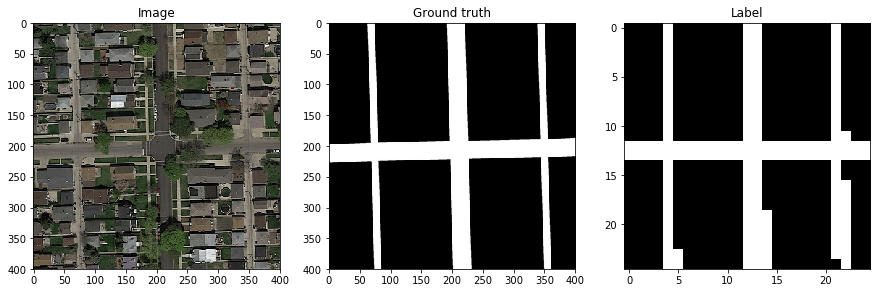

In [5]:
# Test the loading by showing image, ground truth & label
img_num = 0
# Show the image and its groundtruth
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image_train[img_num])
plt.title("Image")
plt.subplot(132)
plt.imshow(gt_train[img_num], cmap='gray')
plt.title("Ground truth")
plt.subplot(133)
plt.imshow(label_train[img_num], cmap='gray')
plt.title("Label")

## 1.2 Pre-process the data
Do pre-processing here, e.g. edge detection, etc.
Can add the results as an additional channel in the training images.

In [6]:
# Pre-processing; currently, do nothing
x_train = image_train.copy()
y_train = label_train.copy()
print(x_train.shape, y_train.shape)

(100, 400, 400, 3) (100, 25, 25)


## 1.3 Window extraction
Define functions to extract a window around each patch of pixels in x_train.

In [7]:
def get_window(image, window_size, i, j):
    """
    Extract a window in image, with the top left corner at (i,j) (mirror boundary conditions apply)
    Note that (i,j) = (y,x) in pixel coordinate (assuming image conventions)
    Input:
        image: the image array; size:(height, width, num_channel)
        window_size: size of the window to extract
        i: the row-coordinate of the window's top-left corner
        j: the col-coordinate of the window's top-left corner
    Output:
        window: the window array; size:(window_size, window_size, num_channel)
    """
    window = np.zeros((window_size, window_size, image.shape[2]))
    for ii in range(window_size):
        for jj in range(window_size):
            window[ii,jj,:] = ip.get_pixel(image, i + ii, j + jj)
    return window

def shift_window(image, window, i, j, stride=1):
    """
    Shift the window to the right by 'stride' pixels on the image (mirror boundary conditions apply)
    Note that (i,j) = (y,x) in pixel coordinate (assuming image conventions)
    Input:
        image: the image array; size:(height, width, num_channel)
        window: the window array; size:(window_size, window_size, num_channel)
        i: the row-coordinate of the window's top-left corner
        j: the col-coordinate of the window's top-left corner
        stride: the number of pixel to move the window (default: 1)
    Output:
        new_window: the shifted window; size:(window_size, window_size, num_channel)
    """
    window_size = window.shape[0]
    new_window = np.zeros(window.shape)
    new_i = i
    new_j = j + stride

    # If stride is too big, so no overlap between windows, return a new window
    if stride >= window_size:
        return get_window(image, window_size, new_i, new_j)
    
    # Else, delete first 'stride' columns, and insert 'stride' new ones at the end of the window
    new_window[:,:window_size-stride,:] = window[:,stride:,:]
    for ii in range(window_size):
        for jj in range(window_size-stride, window_size):
            new_window[ii,jj,:] = ip.get_pixel(image, new_i + ii, new_j + jj)
    return new_window
    

def image_to_windows(image, window_size=PATCH_SIZE):
    """
    Return the windows around each patch of pixels of the given image (mirror boundary conditions apply)
    Input:
        image: the image array; size:(height, width, num_channel)
        window_size: size of the windows, should be even and bigger than PATCH_SIZE (default: PATCH_SIZE)
    Output:
        windows: the windows array; size:(height*width/PATCH_SIZE**2, window_size, window_size, num_channel)
    """
    height, width, _ = image.shape
    # Offset between top-left corners of patch and window
    offset = -(window_size - PATCH_SIZE)//2
    windows_list = []
    
    # Get first window of the row, then loop on the columns
    for i in range(offset, height+offset, PATCH_SIZE):
        window = get_window(image, window_size, i, offset)
        windows_list.append(window)
        for j in range(offset, width-PATCH_SIZE+offset, PATCH_SIZE):
            window = shift_window(image, window, i, j, stride=PATCH_SIZE)
            windows_list.append(window)
    
    windows = np.asarray(windows_list)
    return windows

def extract_windows(images, window_size=PATCH_SIZE):
    """
    Return the windows around each patch of pixels of every images (mirror boundary conditions apply)
    Input:
        images: the images array; size:(num_images, height, width, num_channel)
        window_size: size of the windows, should be even and bigger than PATCH_SIZE (default: PATCH_SIZE)
    Output:
        windows: the windows array; size:(num_images, height*width/PATCH_SIZE**2, window_size, window_size, num_channel)
    """
    windows = []
    for i in range(0, images.shape[0]):
        windows.append(image_to_windows(images[i], window_size=window_size))
    return np.asarray(windows)

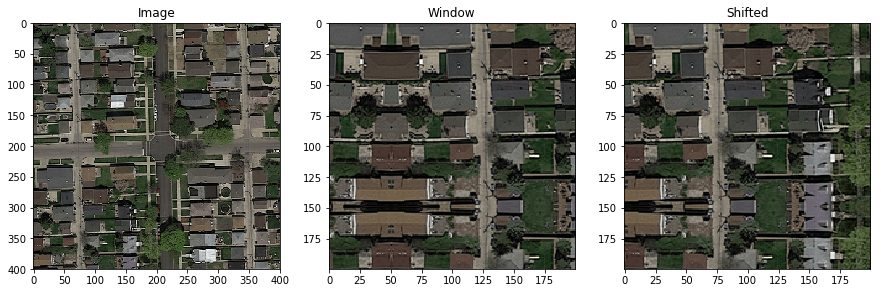

In [8]:
# Test neighbourhood by showing image and pixel's neighbourhood
# Can check if mirror boundary works too
wind = get_window(x_train[img_num], 200, 250, -50)
shifted = shift_window(x_train[img_num], wind, 250, -50, stride=50)

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(x_train[img_num])
plt.title("Image")
plt.subplot(132)
plt.imshow(wind)
plt.title("Window")
plt.subplot(133)
plt.imshow(shifted)
plt.title("Shifted")

In [9]:
# Test windows extraction
# %timeit extract_windows(x_train, window_size=50)

In [10]:
# Test windows extraction
# test_windows = extract_windows(x_train, window_size=50)
# print(test_windows.shape)

# plt.figure(figsize=(10,10))
# plt.subplot(121)
# plt.imshow(test_windows[0][0])
# plt.subplot(122)
# plt.imshow(test_windows[0][1])

## 1.4 Additional functions

In [11]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)

    indices = np.random.permutation(y.shape[0])
    train_size = int(y.shape[0] * ratio)

    x_train, y_train = x[indices[:train_size]], y[indices[:train_size]]
    x_test, y_test = x[indices[train_size:]], y[indices[train_size:]]
    return x_train, y_train, x_test, y_test

# 2 Learning

**For now, only CPU. TODO: add GPU possibility**

## 2.1 Definition
1. Datasets and Dataloaders
2. Model
3. Loss function
4. Optimizer

In [12]:
class NN(torch.nn.Module):
    """
    Class implementing a Neural Network as a PyTorch Module
    """
    
    def __init__(self, window_size, num_channel):
        """
        Initialize the neural network, the input size depends on how many pixels are fed to it
        Input:
            window_size: size of the window around each pixel patch (should be a multiple of 4)
            num_channel: number of channels in the image patches (default: 3, i.e. RGB)
        """
        super(NN, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, 5, kernel_size=5),
            torch.nn.BatchNorm2d(5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(5, 10, kernel_size=5),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(10 * ((window_size-12)//4)**2, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """
        Perform a foward pass, by appling the model to the input x
        Input:
            x: an image window; size:(window_size, window_size, num_channel)
        Output:
            y_pred: the predicted label of the patch
        """
        h1 = self.layer1(x)
        h2 = self.layer2(h1)
        h2 = h2.view(h2.size(0), -1)
        y_pred = self.fc(h2)
        return y_pred

In [27]:
class roadDataset(torch.utils.data.Dataset):
    """
    Road segmentation dataset
    """
    
    def __init__(self, windows, labels=None, train=True):
        """
        Initialize the dataset with the given windows and labels
        Input:
            windows: the windows array; size:(num_window, window_size, window_size, num_channel)
            labels: the label array; size:(num_window,)
                    (default: None) -> reserved for test sets
            train: is this dataset a train set i.e., does it have labels? (default: True)
            
        """
        # From NxHxWxC to NxCxHxW for PyTorch
        windows = windows.transpose((0,3,1,2))
        self.windows = torch.from_numpy(windows).double()
        self.train = train
        if self.train:
            self.labels = torch.from_numpy(labels).double()
        
    def __len__(self):
        return self.windows.shape[0]
    
    def __getitem__(self, idx):
        if self.train:
            return self.windows[idx], self.labels[idx]
        else:
            return self.windows[idx], 0

In [14]:
seed = 1
np.random.seed(seed=seed)
torch.manual_seed(seed)
ratio = 0.8
# Hyper-parameters
num_epoch = 5
batch_size = 25
learning_rate = 1e-3
window_size = 48

# Extract windows for each patches
start = time.time()
tx = extract_windows(x_train, window_size=window_size)
ty = y_train.reshape((y_train.shape[0], -1))
end = time.time()
print("Created windows in %.3f seconds." % (end-start))
# Split data, and creat dataset loader
x_tr, y_tr, x_te, y_te = split_data(tx.reshape((-1,window_size,window_size,tx.shape[-1])),
                                    ty.ravel(),
                                    ratio, seed=seed)
train_dataset = roadDataset(x_tr, y_tr)
test_dataset = roadDataset(x_te, y_te)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

network = NN(window_size, tx.shape[-1]).double()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

Created windows in 120.961 seconds.


## 2.2 Train the network

In [15]:
def train(train_loader, model, loss_fn, optimizer, num_epoch, verbose=False):
    """
    Train the neural networks with the given images and their labels.
    Input:
        train_loader: the PyTorch train loader with the training dataset
        model: the PyTorch model (the neural network)
        loss_fn: the PyTorch loss function
        optimizer: the PyTorch optimizer
        num_epoch: the number of epoch <=> number of pass over the data
        verbose: boolean to choose to print or not the current status (default: False)
    """
    # Change model to 'train' mode (useful for Dropout and BatchNormalization)
    model.train()
    for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
            
            preds = model(images)
            loss = loss_fn(preds, labels)
            
            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0 and verbose:
                print ('Epoch [%2d/%2d], Batch [%3d], Loss: %.4f' 
                       %(epoch+1, num_epoch, i+1, loss.data[0]))

In [16]:
start = time.time()
train(
    train_loader=train_loader,
    model=network,
    loss_fn=loss,
    optimizer=optimizer,
    num_epoch=num_epoch,
    verbose=True
)
end = time.time()
print("Trained network in %.3f seconds." % (end - start))

Epoch [ 1/ 5], Batch [100], Loss: 0.1661
Epoch [ 1/ 5], Batch [200], Loss: 0.1136
Epoch [ 1/ 5], Batch [300], Loss: 0.1641
Epoch [ 1/ 5], Batch [400], Loss: 0.1502
Epoch [ 1/ 5], Batch [500], Loss: 0.1306
Epoch [ 1/ 5], Batch [600], Loss: 0.1595
Epoch [ 1/ 5], Batch [700], Loss: 0.2414
Epoch [ 1/ 5], Batch [800], Loss: 0.1175
Epoch [ 1/ 5], Batch [900], Loss: 0.2170
Epoch [ 1/ 5], Batch [1000], Loss: 0.0807
Epoch [ 1/ 5], Batch [1100], Loss: 0.0939
Epoch [ 1/ 5], Batch [1200], Loss: 0.1069
Epoch [ 1/ 5], Batch [1300], Loss: 0.0928
Epoch [ 1/ 5], Batch [1400], Loss: 0.1660
Epoch [ 1/ 5], Batch [1500], Loss: 0.1066
Epoch [ 1/ 5], Batch [1600], Loss: 0.1094
Epoch [ 1/ 5], Batch [1700], Loss: 0.1541
Epoch [ 1/ 5], Batch [1800], Loss: 0.1227
Epoch [ 1/ 5], Batch [1900], Loss: 0.0940
Epoch [ 1/ 5], Batch [2000], Loss: 0.1648
Epoch [ 2/ 5], Batch [100], Loss: 0.1506
Epoch [ 2/ 5], Batch [200], Loss: 0.1131
Epoch [ 2/ 5], Batch [300], Loss: 0.0858
Epoch [ 2/ 5], Batch [400], Loss: 0.1207
Epoch

## 2.3 Test the predictions

In [58]:
def test(test_loader, model):
    """
    Test the neural networks with the given images and their labels.
    Input:
        images: the PyTorch train loader with the training dataset
        model: the PyTorch model (the neural network)
        loss_fn: the PyTorch loss function
        optimizer: the PyTorch optimizer
        num_epoch: the number of epoch <=> number of pass over the data
        verbose: boolean to choose to print or not the current status (default: False)
    """
    # Change model to 'eval' mode (useful for Dropout and BatchNormalization)
    model.eval()
    
    correct = 0
    total = 0
    prediction = []
    true_label = []
    
    for images, labels in test_loader:
        images = Variable(images)
        preds = model(images).data.view(labels.shape)
        
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        prediction.append(preds.numpy())
        true_label.append(labels.numpy())
    
    prediction = np.asarray(prediction).ravel().astype(int)
    true_label = np.asarray(true_label).ravel().astype(int)
    print("Correct : %d/%d  (%.2f %%)" % (correct, total, 100 * correct / total))
    print("F1-score = ", f1_score(true_label, prediction))

In [59]:
test(
    test_loader=test_loader,
    model=network
)

Correct : 10657/12500  (85.26 %)
F1-score =  0.70676213206


## 2.4 Cross-validation
Repeat the previous step with cross-validation

# 3 Post-process the labels

## 3.1 Create predictions array

In [31]:
def predict_label(data_loader, model):
    """
    Create predicted label on the data with the model
    Input:
        data_loader: a PyTorch DataLoader with a roadDataset to label
                     the batch_size HAVE to be equal to (image_size//PATCH_SIZE)**2, i.e. one image per batch
        model: a Python Module to make the prediction
    Output:
        prediction: a label array with the prediction of the images of the data_loader
    """
    # Change model to 'eval' mode (useful for Dropout and BatchNormalization)
    model.eval()
    
    prediction = []
    # Loop on each batch/image
    for images, _ in data_loader:
        images = Variable(images)
        preds = model(images).data
        
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        
        prediction.append(preds.numpy().reshape((int(np.sqrt(preds.shape[0])), -1)))
    return np.asarray(prediction)

In [33]:
dataset = roadDataset(tx.reshape((-1,window_size,window_size,tx.shape[-1])), ty.ravel())
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=PATCH_NUM**2, 
                                          shuffle=False)
start = time.time()
prediction = predict_label(data_loader=data_loader, model=network)
end = time.time()
print("Prediction computed in %.3f seconds." % (end - start))
print(prediction.shape)

Prediction computed in 93.696 seconds.
(100, 25, 25)


Accuracy on image #0: 88.96 %
F1-score on image #0: 0.754448


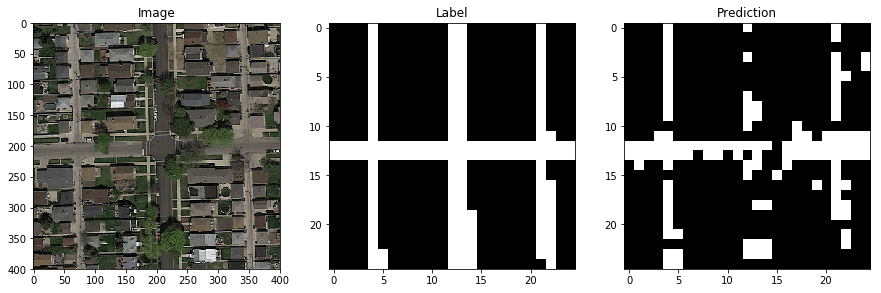

In [63]:
img_num = 0

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(x_train[img_num])
plt.title("Image")
plt.subplot(132)
plt.imshow(y_train[img_num], cmap='gray')
plt.title("Label")
plt.subplot(133)
plt.imshow(prediction[img_num], cmap='gray')
plt.title("Prediction")

print("Accuracy on image #%d: %.2f %%" % (img_num, 100*(y_train[img_num] == prediction[img_num]).mean()))
print("F1-score on image #%d: %f" % (img_num, f1_score(y_train[img_num].ravel(), prediction[img_num].ravel())))

## 3.2 Process the predictions

In [44]:
# For now nothing
pred_label = prediction.astype(int)

# 4 Create a submission

## 4.1 Load the test set

In [22]:
# Directory name
test_dir = "test_set_images/"

te_image_dir  = os.listdir(test_dir)

# Number of testing samples
N_te = len(te_image_dir)

# Load the images
image_test = []
for i in range(N_te):
    image_name = os.listdir(test_dir + te_image_dir[i])[0]
    image = mpimg.imread(test_dir + te_image_dir[i] + "/" + image_name)
    
    image_test.append(image)

image_test = np.asarray(image_test)

print(image_test.shape)

(50, 608, 608, 3)


## 4.2 Predict the labels

In [35]:
# Pre-processing; currently nothing
x_test = image_test.copy()
print(x_test.shape)

start = time.time()
kaggle_pred = []
# Because of memory problem, loop on images
for i in range(x_test.shape[0]):
    print("Computing prediction %d/%d" % (i+1, x_test.shape[0]))
    # Extract windows for each patches
    tx_kaggle = image_to_windows(x_test[i], window_size=window_size)
    
    # Create a data loader
    kaggle_dataset = roadDataset(tx_kaggle, train=False)
    kaggle_loader = torch.utils.data.DataLoader(dataset=kaggle_dataset,
                                                batch_size=len(kaggle_dataset), 
                                                shuffle=False)
    
    # Predict the labels
    kaggle_pred.append(predict_label(kaggle_loader, network)[0])

kaggle_pred = np.asarray(kaggle_pred)
print(kaggle_pred.shape)
end = time.time()
print("Predicted test set in %.3f seconds." % (end-start))

(50, 608, 608, 3)
Computing prediction 1/50
Computing prediction 2/50
Computing prediction 3/50
Computing prediction 4/50
Computing prediction 5/50
Computing prediction 6/50
Computing prediction 7/50
Computing prediction 8/50
Computing prediction 9/50
Computing prediction 10/50
Computing prediction 11/50
Computing prediction 12/50
Computing prediction 13/50
Computing prediction 14/50
Computing prediction 15/50
Computing prediction 16/50
Computing prediction 17/50
Computing prediction 18/50
Computing prediction 19/50
Computing prediction 20/50
Computing prediction 21/50
Computing prediction 22/50
Computing prediction 23/50
Computing prediction 24/50
Computing prediction 25/50
Computing prediction 26/50
Computing prediction 27/50
Computing prediction 28/50
Computing prediction 29/50
Computing prediction 30/50
Computing prediction 31/50
Computing prediction 32/50
Computing prediction 33/50
Computing prediction 34/50
Computing prediction 35/50
Computing prediction 36/50
Computing predictio

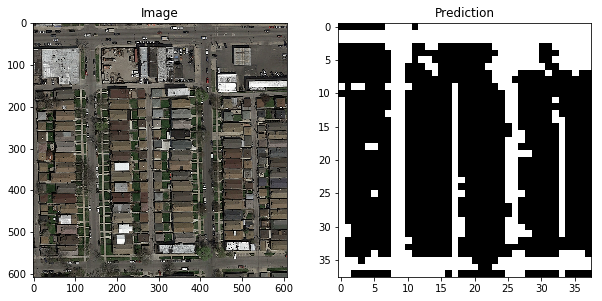

In [50]:
img_num = 0

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(x_test[img_num])
plt.title("Image")
plt.subplot(122)
plt.imshow(kaggle_pred[img_num], cmap='gray')
plt.title("Prediction")

## 4.3 Post-process the predictions

In [45]:
# For now, do nothing
kaggle_label = kaggle_pred.astype(int)
print(kaggle_label.shape)

(50, 38, 38)


## 4.4 Create a submission file

In [47]:
def label_to_submission(img_num, label):
    """
    Generate strings from the label image to the .csv submission file
    Input:
        img_num: the number of the image corresponding to the label array
        label: the label array; size:(image_size/PATCH_SIZE, image_size/PATCH_SIZE)
    """
    for j in range(label.shape[0]):
        for i in range(label.shape[1]):
            yield "{:03d}_{}_{},{}".format(img_num, j*PATCH_SIZE, i*PATCH_SIZE, label[i][j])

def create_submission(filename, labels):
    """
    Create a submssion file (.csv) from the given labels
    Input:
        filename: the name to be given to the file (without the .csv)
        labels: the labels array; size:(num_image, image_size/PATCH_SIZE, image_size/PATCH_SIZE)
    """
    filename += ".csv"
    with open(filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(labels.shape[0]):
            f.writelines('{}\n'.format(s) for s in label_to_submission(i+1, labels[i]))

In [48]:
create_submission("submission", kaggle_label)